<a href="https://colab.research.google.com/github/hsarma/census_income_grp26/blob/main/Group26_Assignment2_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Question-1 - Write Python code to build a neural network.

Implement NN from scratch.

# 1. Required installations and imports

In [207]:
import os
import time
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from six.moves import urllib
from sklearn.metrics import  log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm_notebook


%matplotlib inline
colors = ['red','green','blue','cyan','orange','purple','yellow','black','magenta']


import warnings
warnings.filterwarnings('ignore')

#2. Download the dataset

In [208]:
DATA_DIR = 'data'
DATA_FILE = 'iris.data'
# Copied adult.csv from kaggle to my github repository for easy download
DATA_DOWNLOAD_URL='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

cwdpath = os.getcwd()
abspath = os.path.join(cwdpath, DATA_DIR)
datafile = os.path.join(abspath, DATA_FILE)

#We do not have the data, create data folder and download the csv
if not os.path.exists(datafile):
  os.makedirs( abspath, exist_ok=True)
  urllib.request.urlretrieve(DATA_DOWNLOAD_URL, datafile)
  print('%s downloaded and saved under %s' % (DATA_FILE,abspath))

file_stats = os.stat(datafile)
print('Datafile: %s , size %.2f kb' % ( datafile, (file_stats.st_size / (1024 ))))

data = pd.read_csv(datafile,header=None)
data.shape

Datafile: /content/data/iris.data , size 4.44 kb


(150, 5)

#3. Normalize the data

In [209]:
'''df_norm = data[[0,1,2,3]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
target = data[[4]].replace(['Iris-setosa','Iris-versicolor','Iris-virginica'],[0,1,2])

#the nomalized data
df = pd.concat([df_norm, target], axis=1)
df.head()'''

X=data.drop(4,axis=1)
y=data[4]

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)


#4. Split normalized data into training and test sets, and OH encode the target class since it is multiclass type

In [210]:
#As per the assignment, much of the task is at training, hence reducing the test split size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, stratify=y, random_state = 0)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_OH_test = enc.fit_transform(np.expand_dims(y_test,1)).toarray()


#5. Define activation functions as reusable classes

In [211]:
#The base class
class Activation:
    def __init__(self):
        raise NotImplementedError

    def activation(self, x):
        raise NotImplementedError

    def derivative(self, x):
        raise NotImplementedError


class Logistic(Activation):
    def __init__(self):
        pass

    def activation(self, x):
        return 1.0/(1.0 + np.exp(-x))

    def derivative(self, x):
        s = self.activation(x)
        return s * (1 - s)

class Relu(Activation):
    def __init__(self):
        pass

    def activation(self, x):
      return np.maximum(0,x)

    def derivative(self, x):
        computation = self.activation(x)
        derivatives = np.zeros(computation.shape)
        derivatives[computation > 0] = 1
        return derivatives

class Tanh(Activation):
    def __init__(self):
        pass

    def activation(self, x):
        return np.tanh(x)

    def derivative(self, x):
      return (1-np.square(x))

#6. The NeuralNet implementation as a reusable class

In [212]:
class G26NeuralNet:  
  def __init__(self, activation_obj, n_inputs, n_outputs, hidden_sizes=[10]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.activation_obj = activation_obj
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 
    self.loss = {}
    self.accuracy = {}
    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  #Internal softmax for multiclass output
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  #Forward propogation
  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.activation_obj.activation(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]

  #Predict function, can be used on train/test sets, but we are using for calculating accuracy
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  #Loss function is being calculated as cross entropy, we could as well use MSE for simplicity, but CE will be more accurate
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  #The core logic of the NeuralNet, does a forward and back propogation
  #Backpropogation takes care of updating derivaties in this function
  #The second part of backpropogation, the Stochastic Gradient descent is done in fit function
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.activation_obj.derivative(self.H[k-1])) 
  
  #Utility function to calculate accuracy given expected and predicted value, used for plotting the graph
  def acc(self, y, yhat):
        '''
        Calculates the accuracy between the predicted valuea and the truth labels
        '''
        #acc = accuracy_score(y,yhat)
        #return accuracy_score( np.array(yhat).squeeze(),self.normal_y)
        yhat1 = np.argmax(yhat, axis=1)
        y1 = np.argmax(y,axis=1)
        acc = int(sum(y1 == yhat1) / len(y1) * 100)
        return acc

  #The entry point into the NeuralNet
  def fit(self, X, Y, epochs=5000, learning_rate=0.0001):
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
    
    #Capture start time, we consider the above part of initialization is common across all 
    #activation functions and would be constant for a model of NN
    start_time = time.time()
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                  
      m = X.shape[1]
      '''
           Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
      '''
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
        
      
      Y_pred = self.predict(X) 
      self.loss[epoch] = self.cross_entropy(Y, Y_pred)
      self.accuracy[epoch] = self.acc(Y, Y_pred)
    
    #Capture end time and compute total time taken
    self.execution_time = round(time.time() - start_time,2)
    self.model_avg_accuracy = np.average(list(self.accuracy.values()))
    self.model_end_accuracy = self.accuracy[epochs-1]


#7. Get required information about the dataset

In [213]:
num_observations = data.shape[0]
num_features = data.shape[1] - 1 # substract 2 because we have added an extra column for test/train split
num_classes = len(pd.unique(data[4]))
print ("# of observations:", num_observations, ", #of features:", num_features, ", #of target classes:", num_classes)

# of observations: 150 , #of features: 4 , #of target classes: 3


We have 150 observations and 4 features, which means the input layer in our NN will have 4 nodes and the output layer will have 3 nodes.

#8. Define the Hyperparameters as required by the assignment

In [214]:
hidden_layer_size = 10
num_iterations = 5000
learning_rate = 0.0001

#9 Train 3 different NeuralNet using Logistic, Relu and Tanh activations

In [215]:
log_activation_obj = Logistic() #From the activation class defined in Step#5
logistic_nn = G26NeuralNet(log_activation_obj,num_features,num_classes,[hidden_layer_size])
logistic_nn.fit(X_train, y_OH_train,epochs=num_iterations,learning_rate=learning_rate)


relu_activation_obj = Relu() #From the activation class defined in Step#5
relu_nn = G26NeuralNet(relu_activation_obj,num_features,num_classes,[hidden_layer_size])
relu_nn.fit(X_train, y_OH_train,epochs=num_iterations,learning_rate=learning_rate)

tanh_activation_obj = Tanh() #From the activation class defined in Step#5
tanh_nn = G26NeuralNet(tanh_activation_obj,num_features,num_classes,[hidden_layer_size])
tanh_nn.fit(X_train, y_OH_train,epochs=num_iterations,learning_rate=learning_rate)


#10 Plot the loss curve and training score/accuracy of the netwoks

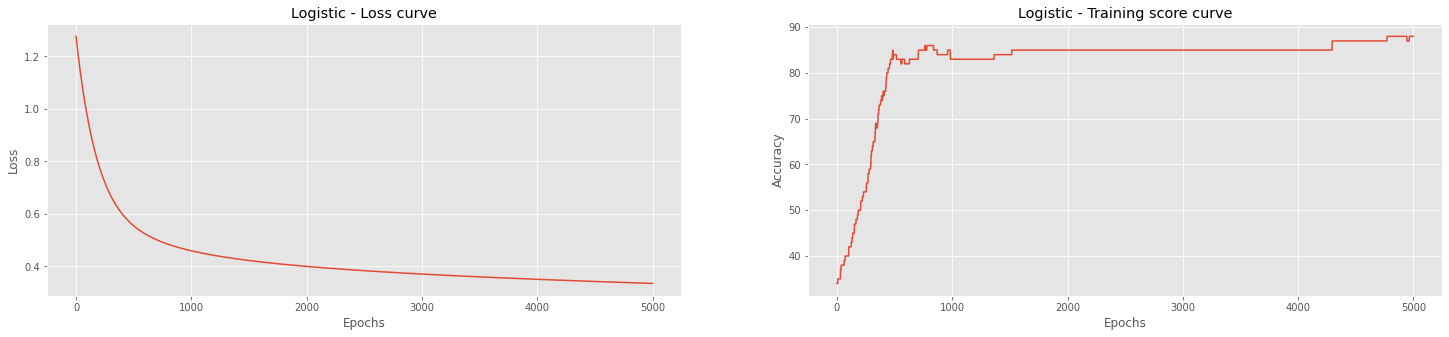

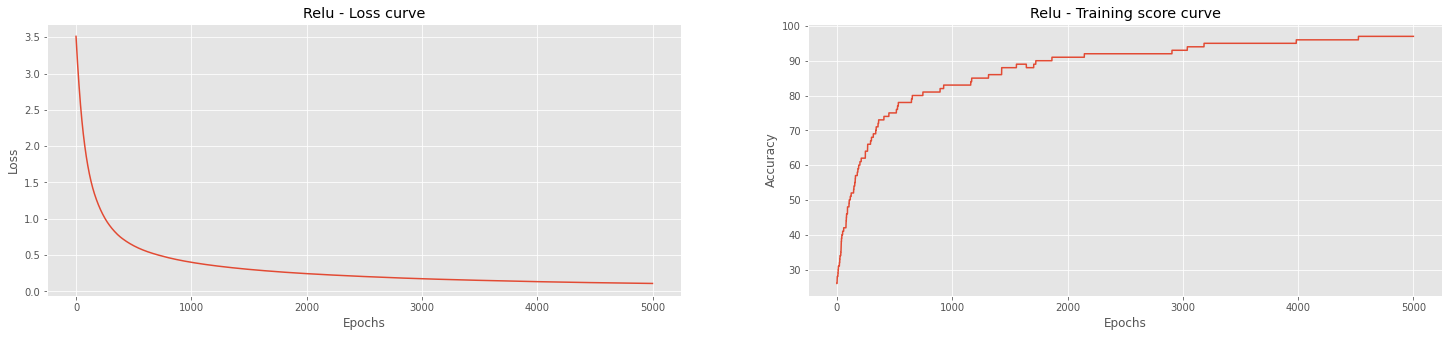

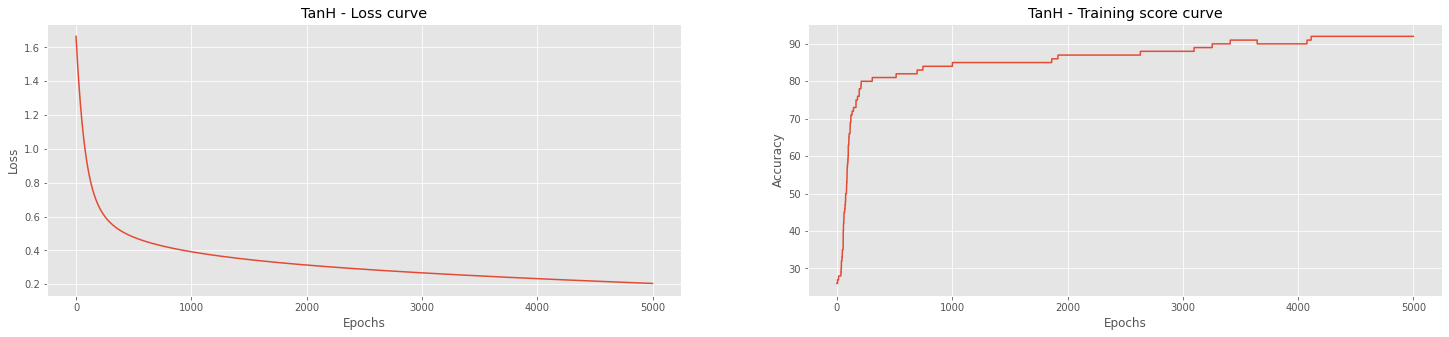

In [216]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (25,5)

#Utility function to plot the loss curve and training accuracy over epochs,
def plot_info( for_what,loss, accuracy):
 plt.tight_layout()
 plt.subplot(1,2,1)
 plt.plot(np.array(list(loss.values())).astype(float))
 plt.xlabel('Epochs')
 plt.ylabel('Loss')
 plt.title(for_what + ' - Loss curve')

 plt.subplot(1,2,2)
 plt.plot(np.array(list(accuracy.values())).astype(float))
 plt.xlabel('Epochs')
 plt.ylabel('Accuracy')
 plt.title(for_what + ' - Training score curve')

 plt.show()


plot_info('Logistic', logistic_nn.loss, logistic_nn.accuracy)
plot_info('Relu', relu_nn.loss, relu_nn.accuracy)
plot_info('TanH', tanh_nn.loss, tanh_nn.accuracy)


#11. Plot performance metrics of various activation functions

<Figure size 1440x360 with 0 Axes>

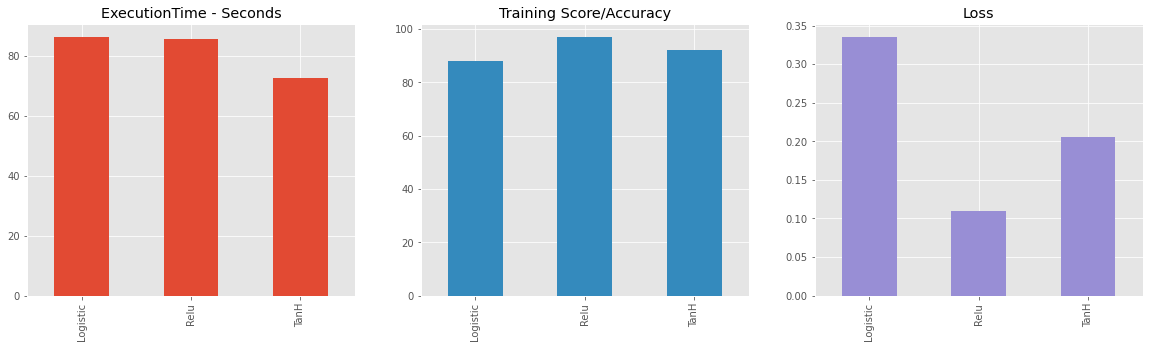

In [217]:
plt.rcParams["figure.figsize"] = (20,5)
plt.tight_layout()

execution_times = [logistic_nn.execution_time, relu_nn.execution_time, tanh_nn.execution_time]
accuracy = [logistic_nn.model_end_accuracy, relu_nn.model_end_accuracy, tanh_nn.model_end_accuracy]
end_loss = [logistic_nn.loss[num_iterations-1], relu_nn.loss[num_iterations-1], tanh_nn.loss[num_iterations-1]]

index = ['Logistic', 'Relu', 'TanH']

df = pd.DataFrame({'ExecutionTime-Sec': execution_times,
                   'Accuracy': accuracy,
                   'End_Loss': end_loss}, index=index)

axis = df.plot(kind='bar',subplots=True,layout=(1,3),legend=False, title=['ExecutionTime - Seconds','Training Score/Accuracy','Loss'])